In [97]:
#%matplotlib notebook
import numpy as np
import cv2 
import os
import sys
import json 

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec as gs
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('default')

# interactive stuff
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



DEF_POINT_SIZE=plt.rcParams['lines.markersize'] ** 2
PLOT_EXPENSIVE=False

DATA_PATH = "segments/vlc_snaps/"
JSON_NAME = "via_region_data.json"
JSON_PATH = os.path.join(DATA_PATH,JSON_NAME)

if os.path.isfile(JSON_PATH):
    # we load the json
    json_file=open(JSON_PATH)
    annnotations_raw=json.load(json_file)


bootstrap_scenes_hsv = []
bootstrap_scenes_rgb = []

bootstrap_cones = []
bootstrap_cones_hsv = []
bootstrap_cones_rgb = []
bootstrap_cones_mask = []

for k,v in annnotations_raw.items():
    img=cv2.imread(os.path.join(DATA_PATH,v["filename"]))
    img = cv2.GaussianBlur(img,(5, 5), 0)
    
    bootstrap_scenes_hsv.append(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    bootstrap_scenes_rgb.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    if "regions" in v:
        for rk,rv in v["regions"].items():
            shape = rv["shape_attributes"]
            
            if shape["name"]=="rect":
                
                bootstrap_cones.append(img[shape["y"]:shape["y"] + shape["height"],
                                           shape["x"]:shape["x"] + shape["width"]])
                bootstrap_cones_hsv.append(cv2.cvtColor(bootstrap_cones[-1], cv2.COLOR_BGR2HSV))
                bootstrap_cones_rgb.append(cv2.cvtColor(bootstrap_cones[-1], cv2.COLOR_BGR2RGB))
                



Basic image manipulation: blurring, Canny edge detection, Otsu thresholding, morfoligical operations
---

This section investigates the power of basic image operations for determining a mask for the cone.


In [98]:
def avg_color(img, mask):
    pixels = img[mask>0]
    
    return np.mean(pixels, axis = 0)




def slideshow_callback1(img_idx, plot = True):
    
    orig_img_rgb = bootstrap_cones_rgb[img_idx]
    orig_img_hsv = bootstrap_cones_hsv[img_idx]
    
    gauss_img = orig_img_hsv
    gauss_img_rgb = orig_img_rgb
    
    canny_img = cv2.Canny(gauss_img[:,:,1], 0, 255)
    
    th_val, otsu_img = cv2.threshold(gauss_img[:,:,1], 0, 255, cv2.THRESH_OTSU)
    
    if not plot:
        bootstrap_cones_mask.append(otsu_img)
    
    canny_otsu_img = cv2.Canny(otsu_img, 0, 255)
    
    # make mean color image
    a_col_rgb = avg_color(orig_img_rgb, otsu_img)
    a_col_hsv = avg_color(orig_img_hsv, otsu_img) # lazy to convert :)
    
    avg_img = np.zeros_like(orig_img_rgb)
    avg_img[:,:] = a_col_rgb
    
    # mask img
    masked_img = np.zeros_like(orig_img_rgb)
    
    mask_idx = otsu_img > 0
    
    masked_img[mask_idx] = orig_img_rgb[mask_idx]
    
    
    kernel= np.ones((3, 3), np.uint8)
    morph_img = cv2.morphologyEx(otsu_img, cv2.MORPH_ERODE, kernel, iterations=1)
  
    if plot:
        fig, ax = plt.subplots(2, 4, figsize = (20, 10))

        ax[0][0].set_title("Original image")
        ax[0][0].imshow(orig_img_rgb)

        ax[0][1].set_title("S channel")
        ax[0][1].imshow(orig_img_hsv[:, :, 1], cmap = "gray", vmin = 0, vmax = 255)

        ax[0][2].set_title("Otsu threshold of H channel " + str(th_val))
        ax[0][2].imshow(otsu_img, cmap = "gray",vmin = 0, vmax = 255)

        ax[1][0].set_title("Gaussian blur")
        ax[1][0].imshow(gauss_img_rgb)

        ax[1][1].set_title("Gaussian blur")
        ax[1][1].imshow(gauss_img[:, :, 1], cmap = "gray")

        ax[1][2].set_title("Edges of thresholded image")
        ax[1][2].imshow(canny_otsu_img, cmap = "gray")

        ax[0][3].set_title("Eroded mask:\n" + str(np.round(a_col_hsv)))
        ax[0][3].imshow(morph_img, cmap = "gray")

        ax[1][3].set_title("Masked image")
        ax[1][3].imshow(masked_img)

        plt.show()
    
for i in range(len(bootstrap_cones_hsv)):
    slideshow_callback1(i, plot = False)  

w = widgets.IntSlider(value=40, min=0, max=len(bootstrap_cones)-1, continuous_update = False)   
interact(slideshow_callback1, img_idx = w)

interactive(children=(IntSlider(value=40, continuous_update=False, description='img_idx', max=184), Checkbox(value=True, description='plot'), Output()), _dom_classes=('widget-interact',))

<function __main__.slideshow_callback1>

## Histogram backprojection


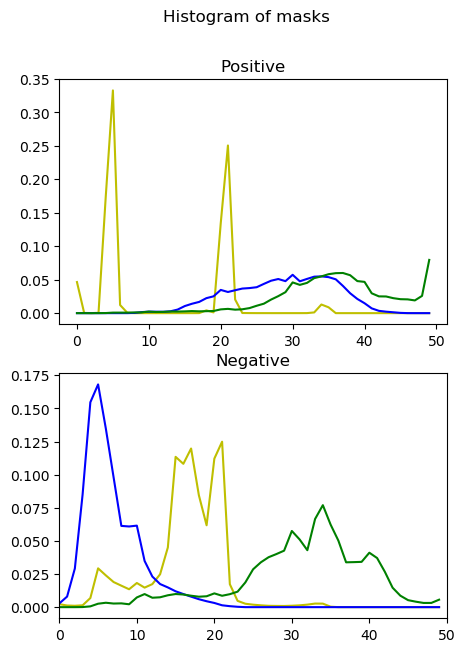

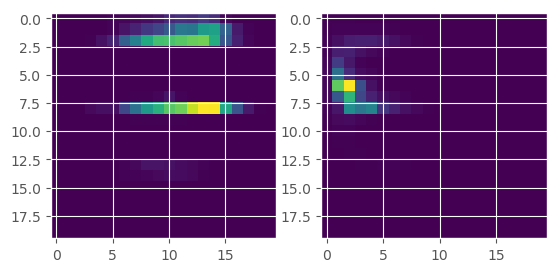

In [99]:
hist = dict(zip("hsv", [None]*3))
hist_neg = dict(zip("hsv", [None]*3))

hist2d = None
hist2d_neg = None

BINS = 50
BINS2D = 20

for i in range(len(bootstrap_cones_mask)):
    
    hist2d = cv2.calcHist([bootstrap_cones_hsv[i]], [0,1],  bootstrap_cones_mask[i],
                          [BINS2D]*2, 
                          [0,255]*2, 
                          hist=hist2d,
                          accumulate=True)
    
    hist2d_neg = cv2.calcHist([bootstrap_cones_hsv[i]], [0,1],  (255-bootstrap_cones_mask[i]),
                          [BINS2D]*2, 
                          [0,255]*2, 
                          hist=hist2d_neg,
                          accumulate=True)
    
    for j, c in enumerate("hsv"):
        hist[c] = cv2.calcHist([bootstrap_cones_hsv[i]], [j], bootstrap_cones_mask[i], [BINS], [0,255], 
                               hist = hist[c], accumulate = True)
        hist_neg[c] = cv2.calcHist([bootstrap_cones_hsv[i]], [j], (255-bootstrap_cones_mask[i]), [BINS], [0,255], 
                       hist = hist_neg[c], accumulate = True)
fig, ax = plt.subplots(2,1, figsize = (5, 7))
fig.suptitle("Histogram of masks")

for i, c in enumerate("hsv"):
    hist[c] /= np.sum(hist[c])
    hist[c] = np.squeeze(hist[c])
    hist_neg[c] /= np.sum(hist_neg[c])
    hist_neg[c] = np.squeeze(hist_neg[c])
    
    ax[0].plot(hist[c], color = "ybg"[i])
    ax[1].plot(hist_neg[c], color = "ybg"[i])

ax[0].set_title("Positive")
ax[1].set_title("Negative")
plt.xlim([0,BINS])
plt.style.use('ggplot')
plt.show()

# 2D


hist2d = hist2d / np.sum(hist2d)
hist2d = np.squeeze(hist2d)
hist2d_neg = hist2d_neg / np.sum(hist2d_neg)
hist2d_neg = np.squeeze(hist2d_neg)

fig, ax = plt.subplots(1,2)
ax[0].imshow(hist2d)
ax[1].imshow(hist2d_neg)

plt.show()

In [109]:
bootstrap_scenes_mask = []


def backproject_patch()

def slideshow_callback_histo(scene_idx, plot = True):
    scene_img = bootstrap_scenes_hsv[scene_idx]
    #scene_img = cv2.GaussianBlur(scene_img,(5, 5), 0)

    prob_map = np.zeros(scene_img.shape[:-1], dtype = "float32")

    pos = np.ones(scene_img.shape[:-1], dtype = "float32")
    neg = np.ones(scene_img.shape[:-1], dtype = "float32")

    for ic,c in enumerate("hs"):
        pos = pos * hist[c][np.around(scene_img[:, :, ic] / 255.0 * (BINS-1)).astype(int)]
        neg = neg * hist_neg[c][np.around(scene_img[:, :, ic] / 255.0 * (BINS-1)).astype(int)]

    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        prob_map = pos #/ neg
        prob_map[prob_map == np.inf] = 0
        
    cv2.normalize(prob_map, prob_map, 0, 255, cv2.NORM_MINMAX)
    kernel= np.ones((3,3),np.uint8)
    prob_map = cv2.morphologyEx(prob_map, cv2.MORPH_CLOSE, kernel,iterations=1)
    prob_map = cv2.morphologyEx(prob_map, cv2.MORPH_OPEN, kernel,iterations=1)
    
    bootstrap_scenes_mask.append(prob_map)
    
    
    # 2D probmap
    scene_img_binned = np.around(scene_img / 255.0 * (BINS2D-1)).astype(int)
    
    pos = hist2d[scene_img_binned[:, :, 0], scene_img_binned[:, :, 1]]
    neg = hist2d_neg[scene_img_binned[:, :, 0], scene_img_binned[:, :, 1]]
    
    prob_map_2d = pos
    cv2.normalize(prob_map_2d, prob_map_2d, 127, 255, cv2.NORM_MINMAX)
    
    prob_map_2d = cv2.morphologyEx(prob_map_2d, cv2.MORPH_CLOSE, kernel,iterations=1)
    prob_map_2d = cv2.morphologyEx(prob_map_2d, cv2.MORPH_OPEN, kernel,iterations=1)
    
    th_val, otsu_prob_map_2d = cv2.threshold(prob_map_2d.astype("uint8"), 0, 255, cv2.THRESH_OTSU)
    
    bootstrap_scenes_mask.append(prob_map)

    if plot:
        fig, ax = plt.subplots(3, 1, figsize = (20, 15))
        ax[0].imshow(prob_map, cmap = "gray")
        ax[1].imshow(prob_map_2d, cmap = "gray")
        ax[2].imshow(bootstrap_scenes_rgb[scene_idx])
        plt.show()
        
w = widgets.IntSlider(value=0, min=0, max=len(bootstrap_scenes_rgb)-1)  
interact(slideshow_callback_histo, scene_idx = w)

interactive(children=(IntSlider(value=0, description='scene_idx', max=22), Checkbox(value=True, description='plot'), Output()), _dom_classes=('widget-interact',))

<function __main__.slideshow_callback_histo>

Filtering short contours
---------------------------


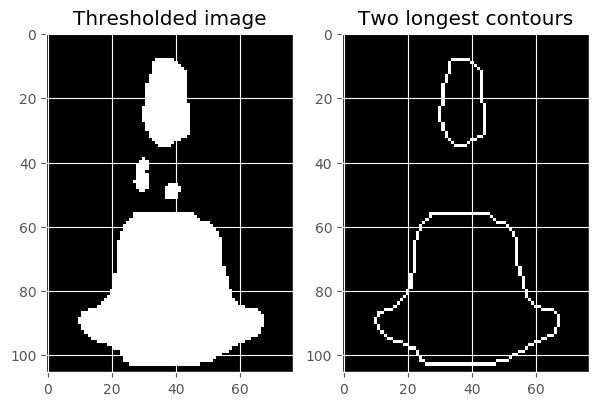

In [101]:
good_shapes = [40, 79, 82, 86, 161]
hard_shapes = [71, 0]

def get_top2len(cont):
    if len(cont)<=2:
        return cont
    else:
        cont_lens = np.argsort([len(i) for i in cont])[-2:] # indexes of 2 longest contours
        return [cont[i] for i in cont_lens]
    
def findContours_simple(img):
    return cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

def drawContours_simple(c, shape, img = None, col = (255, 255, 255)):
    if img is None:
        cont_draw_img = np.zeros(shape, dtype = "uint8")
    else:
        cont_draw_img = img
        
    cv2.drawContours(cont_draw_img, c, -1, col, 1) 

    return cont_draw_img
    
SHAPE_IDX = 137 # select an image with more than two contours 
cont_img = bootstrap_cones_mask[SHAPE_IDX]

cont = findContours_simple(cont_img)

cont_top2 = get_top2len(cont)


cont_draw_img = drawContours_simple(cont_top2, cont_img.shape + (3,))

fig, ax = plt.subplots(1, 2, figsize = (7, 15))
ax[0].set_title("Thresholded image")
ax[0].imshow(cont_img, cmap = "gray")

ax[1].set_title("Two longest contours")
ax[1].imshow(cont_draw_img)

plt.show()


Contour/Shape matching
------------------------

This section explores the use of image moments for scale and rotation (parallel projection?) independent matching.


See [`doc/Hu62.pdf`](./doc/Hu62.pdf) and [`matchShapes()`](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#matchshapes) for further detail.


In [102]:
TEMPL_SHAPE_IDX = 40 # good, high res shape of a cone
templ_img = bootstrap_cones_mask[TEMPL_SHAPE_IDX]

templ_cont_img, templ_cont, templ_hier = cv2.findContours(templ_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

test_cont = cont_top2

# cv2.CONTOURS_MATCH_I2 - L1 distance
def matchShapes_simple(cont1, cont2, method = cv2.CONTOURS_MATCH_I1):    
    if len(cont1) < 2 or len(cont2) < 2:
        return [-1, -1]
    else:
        return [cv2.matchShapes(cont1[i], cont2[i], cv2.CONTOURS_MATCH_I2, 0) for i in [0,1]]
    
def shape_distance(cont1, cont2):
    if len(cont1) < 2 or len(cont2) < 2:
        return [-1, -1]
    else:
        sd = cv2.createHausdorffDistanceExtractor()
        return [sd.computeDistance(np.array(cont1[i], dtype = "float64"), np.array(cont2[i], dtype = "float64")) for i in [0,1]]

def slideshow_callback2(templ_img_idx, test_img_idx, plot = True):
    templ_img = bootstrap_cones_mask[templ_img_idx]
    test_img = bootstrap_cones_mask[test_img_idx]
    
    # resize images so they can be superimposed
    templ_img_res = np.zeros_like(test_img, dtype = "uint8")
    
    templ_img = cv2.resize(src = templ_img, dsize = (test_img.shape[1], test_img.shape[0]))

    templ_cont = findContours_simple(templ_img)
    test_cont = findContours_simple(test_img)
    
    if len(test_cont) < 2 or len(templ_cont) < 2:
        return
    
    templ_cont = get_top2len(templ_cont)
    test_cont = get_top2len(test_cont)
    
    #print([len(i) for i in templ_cont])
    
    contour_img = drawContours_simple(templ_cont, templ_img.shape + (3,), col = (255, 0, 0))
    contour_img = drawContours_simple(test_cont, None, contour_img, col = (0, 255, 0))
    
    sc_dist = shape_distance(templ_cont, test_cont)
    #hd_dist = haussdorf_distance(templ_cont, test_cont)
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize = (7, 7))

        ax.set_title("Test contour\n Moments: " + str(np.round(matchShapes_simple(test_cont, templ_cont), 2))
                    + "\nShape context: " + str(np.round(sc_dist, 2)))
        ax.imshow(contour_img)

        plt.show()
    
w = widgets.IntSlider(value=0, min=0, max=len(bootstrap_cones)-1)
w2 = widgets.IntSlider(value=3, min=0, max=len(bootstrap_cones)-1)  
interact(slideshow_callback2, templ_img_idx = w, test_img_idx = w2)

#89

interactive(children=(IntSlider(value=0, description='templ_img_idx', max=184), IntSlider(value=3, description='test_img_idx', max=184), Checkbox(value=True, description='plot'), Output()), _dom_classes=('widget-interact',))

<function __main__.slideshow_callback2>

## Sliding window template matching

This section explores the sliding window method


In [103]:

def get_mask(img):
    gauss_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    th_val, otsu_img = cv2.threshold(gauss_img[:,:,1], 0, 255, cv2.THRESH_OTSU)
    
    return otsu_img

def get_mask_gray(img):
    gauss_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    th_val, otsu_img = cv2.threshold(gauss_img, 0, 255, cv2.THRESH_OTSU)
    
    return otsu_img



def slideshow_callback3(x, y, templ_idx, scene_idx, scale, plot = True):
    scene_img_hsv = bootstrap_scenes_mask[scene_idx].astype("uint8")
    scene_img_rgb = bootstrap_scenes_rgb[scene_idx]
    
    templ_img = bootstrap_cones_mask[templ_idx]
    
    # rescale templ
    templ_img = cv2.resize(src = templ_img, dsize = (0, 0), fx = scale, fy = scale)

    crop_y = templ_img.shape[0] 
    crop_x = templ_img.shape[1]
    
    test_img = scene_img_hsv[y: y + crop_y, x: x + crop_x]
    
    test_img_mask = get_mask_gray(test_img)
    
    # draw focus rect on scene_img
    scene_img_roi = np.copy(scene_img_rgb)
    cv2.rectangle(scene_img_roi, (x, y), (x+crop_x, y+crop_y), (255, 0, 0), thickness = 4)
    
    cont_templ = get_top2len(findContours_simple(templ_img))
    cont_test = get_top2len(findContours_simple(test_img_mask))
    
    test_img_cont = drawContours_simple(get_top2len(cont_test), test_img_mask.shape)
    
    matches = shape_distance(cont_templ, cont_test)
    
    if plot:
        fig, ax = plt.subplots(2, 3, figsize = (20, 10))
        #fig.tight_layout()
        plt.suptitle("Match: " + str(np.round(matches, decimals = 2)), fontsize = 15)

        ax[1][0].set_title("Template")
        ax[1][0].imshow(templ_img)

        ax[0][1].set_title("Scene")
        ax[0][1].imshow(scene_img_roi)

        ax[1][2].set_title("ROI")
        ax[1][2].imshow(test_img_cont)

        plt.show()


SCENE_SIZE = bootstrap_scenes_rgb[0].shape

w_x = widgets.IntSlider(value = 980, min = 0, max = SCENE_SIZE[1], step = 10, continuous_update = True)
w_y = widgets.IntSlider(value = 540, min = 0, max = SCENE_SIZE[0], step = 10, continuous_update = True)
w_templ = widgets.IntSlider(value = 40, min = 0, max = len(bootstrap_cones)-1, continuous_update = False)
w_scene = widgets.IntSlider(value = 0, min = 0, max=len(bootstrap_scenes_rgb)-1, continuous_update = False)
w_scale = widgets.FloatSlider(value = 1.0, min = 0.3, max = 3.0, continuous_update = False)

interact(slideshow_callback3, x = w_x, y = w_y, templ_idx = w_templ, scene_idx = w_scene, scale = w_scale, plot = widgets.fixed(True))

interactive(children=(IntSlider(value=980, description='x', max=1920, step=10), IntSlider(value=540, description='y', max=1080, step=10), IntSlider(value=40, continuous_update=False, description='templ_idx', max=184), IntSlider(value=0, continuous_update=False, description='scene_idx', max=22), FloatSlider(value=1.0, continuous_update=False, description='scale', max=3.0, min=0.3), Output()), _dom_classes=('widget-interact',))

<function __main__.slideshow_callback3>

In [106]:
SCENE_SIZE = bootstrap_scenes_rgb[0].shape


def slideshow_callback4(templ_idx, scene_idx, plot = True):
    scene_img_hsv = bootstrap_scenes_mask[scene_idx]
    scene_img_rgb = bootstrap_scenes_rgb[scene_idx]
    
    templ_img = bootstrap_cones_mask[templ_idx]
    
    WINDOW_STEP = 10
    
    scale_vec = [1.0]

    
    scene_img_roi = np.copy(scene_img_rgb)
    
    for s in scale_vec:
        templ_img = cv2.resize(src = templ_img, dsize = (0, 0), fx = s, fy = s)
        cont_templ = get_top2len(findContours_simple(templ_img))
        
        crop_y = templ_img.shape[0] 
        crop_x = templ_img.shape[1]
        
        x_vec = np.arange(0, SCENE_SIZE[1] - crop_x - 1, WINDOW_STEP)
        y_vec = np.arange(0, SCENE_SIZE[0] - crop_y - 1, WINDOW_STEP)
        for y in y_vec:
            for x in x_vec:
                test_img = scene_img_hsv[y: y + crop_y, x: x + crop_x]
                test_img_mask = get_mask_gray(test_img.astype("uint8"))

                cont_test = get_top2len(findContours_simple(test_img_mask))

                matches = shape_distance(cont_templ, cont_test)
                
                if matches[0] >= 0 and matches[1] >= 0:
                    if matches[0] < 10 and matches[1] < 10:
                        cv2.rectangle(scene_img_roi, (x, y), (x+crop_x, y+crop_y), (255, 0, 0), thickness = 4)
    
    
    
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize = (20, 10))

        ax.set_title("Scene")
        ax.imshow(scene_img_roi)

        plt.show()





w_templ = widgets.IntSlider(value = 40, min = 0, max = len(bootstrap_cones)-1, continuous_update = False)
w_scene = widgets.IntSlider(value = 0, min = 0, max=len(bootstrap_scenes_rgb)-1, continuous_update = False)

interact(slideshow_callback4, templ_idx = w_templ, scene_idx = w_scene, scale = w_scale, plot = widgets.fixed(True))

interactive(children=(IntSlider(value=40, continuous_update=False, description='templ_idx', max=184), IntSlider(value=0, continuous_update=False, description='scene_idx', max=22), Output()), _dom_classes=('widget-interact',))

<function __main__.slideshow_callback4>

As seen above, purely using shape matching isn't working. Next a histogram backprojection will be tried.